In [1]:
#-*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cPickle

from PIL import Image

import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter

import skimage
import skimage.io

from tokenizer.ptbtokenizer import PTBTokenizer
from cider.cider import Cider
from cider.cider_scorer import CiderScorer

class Caption_Generator():
    def init_weight(self, dim_in, dim_out, name=None, stddev=1.0):
        return tf.Variable(tf.truncated_normal([dim_in, dim_out], stddev=stddev/math.sqrt(float(dim_in))), name=name)

    def init_bias(self, dim_out, name=None):
        return tf.Variable(tf.zeros([dim_out]), name=name)

    def __init__(self, dim_image, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, bias_init_vector=None):

        self.dim_image = np.int(dim_image)
        self.dim_embed = np.int(dim_embed)
        self.dim_hidden = np.int(dim_hidden)
        self.batch_size = np.int(batch_size)
        self.n_lstm_steps = np.int(n_lstm_steps)
        self.n_words = np.int(n_words)

        with tf.device("/cpu:0"):
            self.Wemb = tf.Variable(tf.random_uniform([n_words, dim_embed], -0.1, 0.1), name='Wemb')

        self.bemb = self.init_bias(dim_embed, name='bemb')

        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        #self.encode_img_W = self.init_weight(dim_image, dim_hidden, name='encode_img_W')
        self.encode_img_W = tf.Variable(tf.random_uniform([dim_image, dim_hidden], -0.1, 0.1), name='encode_img_W')
        self.encode_img_b = self.init_bias(dim_hidden, name='encode_img_b')

        self.embed_word_W = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='embed_word_W')

        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = self.init_bias(n_words, name='embed_word_b')

    def build_model(self):

        image = tf.placeholder(tf.float32, [self.batch_size, self.dim_image])
        sentence = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])

        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b # (batch_size, dim_hidden)

        state = tf.zeros([self.batch_size, self.lstm.state_size])

        loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): # maxlen + 1
                if i == 0:
                    current_emb = image_emb
                else:
                    with tf.device("/cpu:0"):
                        current_emb = tf.nn.embedding_lookup(self.Wemb, sentence[:,i-1]) + self.bemb

                if i > 0 : tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(current_emb, state) # (batch_size, dim_hidden)

                if i > 0: # 이미지 다음 바로 나오는건 #START# 임. 이건 무시.
                    labels = tf.expand_dims(sentence[:, i], 1) # (batch_size)
                    indices = tf.expand_dims(tf.range(0, self.batch_size, 1), 1)
                    concated = tf.concat([indices, labels], 1)
                    onehot_labels = tf.sparse_to_dense(
                            concated, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0) # (batch_size, n_words)

                    logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b # (batch_size, n_words)
                    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
                    cross_entropy = cross_entropy * mask[:,i]#tf.expand_dims(mask, 1)

                    current_loss = tf.reduce_sum(cross_entropy)
                    loss = loss + current_loss

            loss = loss / tf.reduce_sum(mask[:,1:])
            return loss, image, sentence, mask

    def build_generator(self, maxlen):
        image = tf.placeholder(tf.float32, [1, self.dim_image])
        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b

        state = tf.zeros([1, self.lstm.state_size])
        #last_word = image_emb # 첫 단어 대신 이미지
        generated_words = []

        with tf.variable_scope("RNN"):
            output, state = self.lstm(image_emb, state)
            last_word = tf.nn.embedding_lookup(self.Wemb, [0]) + self.bemb

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(last_word, state)

                logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b
                max_prob_word = tf.argmax(logit_words, 1)

                with tf.device("/cpu:0"):
                    last_word = tf.nn.embedding_lookup(self.Wemb, max_prob_word)

                last_word += self.bemb

                generated_words.append(max_prob_word)

        return image, generated_words

def get_caption_data(train_anno_path, train_feat_path):
     feats = np.load(train_feat_path)
     annotations = np.load(train_anno_path)
#     captions = annotations['caption'].values

     return feats, annotations

def preProBuildWordVocab(sentence_iterator, word_count_threshold=30): # borrowed this function from NeuralTalk
    print 'preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, )
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
      nsents += 1
      for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print 'filtered words from %d to %d' % (len(word_counts), len(vocab))

    ixtoword = {}
    ixtoword[0] = '.'  # period at the end of the sentence. make first dimension be end token
    wordtoix = {}
    wordtoix['#START#'] = 0 # make first vector be the start token
    ix = 1
    for w in vocab:
      wordtoix[w] = ix
      ixtoword[ix] = w
      ix += 1

    word_counts['.'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    return wordtoix, ixtoword, bias_init_vector

def crop_image(x, target_height=227, target_width=227, as_float=True):
    #image = skimage.img_as_float(skimage.io.imread(x)).astype(np.float32)
    image = skimage.io.imread(x)
    if as_float:
        image = skimage.img_as_float(image).astype(np.float32)

    if len(image.shape) == 2:
        image = np.tile(image[:,:,None], 3)
    elif len(image.shape) == 4:
        image = image[:,:,:,0]

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))


def read_image(path):

     img = crop_image(path, target_height=224, target_width=224)
     if img.shape[2] == 4:
         img = img[:,:,:3]

     img = img[None, ...]
     return img
    
  
    
def test_tf(test_image_path=None, model_path='./models/model-72', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)

    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)

    image_val = read_image(test_image_path)
    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})

    fc7_tf, generated_words = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    generated_word_index= sess.run(generated_words, feed_dict={fc7_tf:fc7})
    generated_word_index = np.hstack(generated_word_index)

    generated_words = [ixtoword[x] for x in generated_word_index]
    punctuation = np.argmax(np.array(generated_words) == '.')+1

    generated_words = generated_words[:punctuation]
    generated_sentence = ' '.join(generated_words)
    print generated_sentence


Using TensorFlow backend.


In [2]:
################### 학습 관련 Parameters #####################

dim_embed = 256
dim_hidden = 256
dim_image = 4096
batch_size = 128

#learning_rate = 0.001
n_epochs = 100
###############################################################
#################### 잡다한 Parameters ########################
model_path = './models'
vgg_path = './data/vgg16.tfmodel'
data_path = './data'
train_feat_path = './data/train_feat.npy'
test_feat_path  = './data/test_feat.npy'
train_anno_path = './data/train_caption.npy'
test_anno_path  = './data/test_caption.npy'
annotation_path = os.path.join(data_path, 'results_20130124.token')
################################################################


def train(epoch=0):

    learning_rate = 0.001
    momentum = 0.9
    feats, captions = get_caption_data(train_anno_path, train_feat_path)
    wordtoix, ixtoword, bias_init_vector = preProBuildWordVocab(captions)

    np.save('data/ixtoword', ixtoword)
    np.save('data/wordtoix', wordtoix)

    index = np.arange(len(feats))
    np.random.shuffle(index)

    feats = feats[index]
    captions = captions[index]

    sess = tf.InteractiveSession()
    n_words = len(wordtoix)
    maxlen = np.max( map(lambda x: len(x.split(' ')), captions) )
    caption_generator = Caption_Generator(
            dim_image=dim_image,
            dim_hidden=dim_hidden,
            dim_embed=dim_embed,
            batch_size=batch_size,
            n_lstm_steps=maxlen+2,
            n_words=n_words,
            bias_init_vector=bias_init_vector)

    loss, image, sentence, mask = caption_generator.build_model()

    saver = tf.train.Saver(max_to_keep=50)
    if not epoch == 0:
        saver.restore(sess, 'models/model-' + str(epoch))

    temp = set(tf.all_variables())
    
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    if epoch == 0:
        tf.initialize_all_variables().run()
    else:
        sess.run(tf.initialize_variables(set(tf.all_variables()) - temp))

        
    for epoch in range(epoch, n_epochs):
        #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        for start, end in zip( \
                range(0, len(feats), batch_size),
                range(batch_size, len(feats), batch_size)
                ):
            current_feats = feats[start:end]
            current_captions = captions[start:end]

            current_caption_ind = map(lambda cap: [wordtoix[word] for word in cap.lower().split(' ')[:-1] if word in wordtoix], current_captions)

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=maxlen+1)
            current_caption_matrix = np.hstack( [np.full( (len(current_caption_matrix),1), 0), current_caption_matrix] ).astype(int)

            current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
            nonzeros = np.array( map(lambda x: (x != 0).sum()+2, current_caption_matrix ))
            #  +2 -> #START# and '.'

            for ind, row in enumerate(current_mask_matrix):
                row[:nonzeros[ind]] = 1

            _, loss_value = sess.run([train_op, loss], feed_dict={
                image: current_feats,
                sentence : current_caption_matrix,
                mask : current_mask_matrix
                })

            print "Current Cost: ", loss_value, ", Epoch: ", epoch, ", iteration: ", start, "/", len(feats) 

        print "Epoch ", epoch, " is done. Saving the model ... "
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch+1)
        learning_rate *= 0.95

In [3]:
def bleu_1(reference, candidate):
    #print reference, candidate
    prec = [x for x in candidate if x in reference]
    if len(candidate) == 0:
        return 0
    bleu1 = float(len(prec)) / len(candidate)
    return bleu1

def bleu_2(reference, candidate):
    bi_gram_cand = zip(candidate, candidate[1:])
    bi_gram_ref = zip(reference, reference[1:])
    prec = [[x,y] for x,y in bi_gram_cand if (x,y) in bi_gram_ref]
    if len(bi_gram_cand) == 0:
        return 0
    bleu2 = float(len(prec)) / len(bi_gram_cand)
    return bleu2
                
def bleu_3(reference, candidate):
    tri_gram_cand = zip(candidate, candidate[1:], candidate[2:])
    tri_gram_ref = zip(reference, reference[1:], reference[2:])
    prec = [[x,y,z] for x,y,z in tri_gram_cand if (x,y,z) in tri_gram_ref]
    if len(tri_gram_cand) == 0:
        return 0
    bleu3 = float(len(prec)) / len(tri_gram_cand)
    return bleu3

def bleu_4(reference, candidate):
    quad_gram_cand = zip(candidate, candidate[1:], candidate[2:], candidate[3:])
    quad_gram_ref = zip(reference, reference[1:], reference[2:], reference[3:])
    prec = [[x,y, z, w] for x,y, z, w in quad_gram_cand if (x,y,w,z) in quad_gram_ref]
    if len(quad_gram_cand) == 0:
        return 0
    bleu4 = float(len(prec)) / len(quad_gram_cand)
    return bleu4

In [4]:
def evaluation(test_image_path='data/flickr30k', model_path='./models/model-10', maxlen=30):        
    ixtoword = np.load('./data/ixtoword.npy').tolist()
    wordtoix = np.load('./data/wordtoix.npy').tolist()

    n_words = len(ixtoword)
    
    filename = np.load('./data/test_file.npy')
    test_feat = np.load('./data/test_feat.npy')
    
    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    fc7_tf, generated_word = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    gt_cap = np.load('./data/test_caption.npy')
    
    res = {}
    bleu1 = 0.0 ; bleu2 = 0.0 ; bleu3 = 0.0 ; bleu4 = 0.0 ; 
    for i in range(0, len(test_feat)):
        image_feat = np.reshape(test_feat[i], (1, -1))
        image = filename[i]
        
        generated_word_index= sess.run(generated_word, feed_dict={fc7_tf:image_feat})
        generated_word_index = np.hstack(generated_word_index)

        generated_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.')+1
        
        generated_word_index = generated_word_index[:punctuation-1]
        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        
        if i % 50 == 0:
            PIL_image = Image.open(os.path.join(test_image_path, image))
            fig,ax=plt.subplots(1,1)
            ax.imshow(PIL_image)
            plt.show()
            
            print generated_sentence
        
        res[image] = [{}]
        res[image][0]['caption'] = generated_sentence
        res[image][0]['image_id'] = image
        
        gt_sentence = gt_cap[range(i * 5, (i + 1) * 5)]
        gt_words_index = [wordtoix[word] for x in gt_sentence for word in x.lower().split(' ') if word in wordtoix]
        
        
        bleu1 = bleu1 + bleu_1(gt_words_index, generated_word_index)
        bleu2 = bleu2 + bleu_2(gt_words_index, generated_word_index)
        bleu3 = bleu3 + bleu_3(gt_words_index, generated_word_index)
        bleu4 = bleu4 + bleu_4(gt_words_index, generated_word_index)
    
    gts = {}
    
    cnt = 0
    for name in filename:
        gts[name] = [{}, {}, {}, {}, {}]
        for j in range(0, 5):
            gts[name][j]['caption'] = gt_cap[cnt]
            gts[name][j]['image_id'] = name
            cnt += 1
    
    tokenizer = PTBTokenizer()
    gts = tokenizer.tokenize(gts)
    res = tokenizer.tokenize(res)
    
    cider = Cider()
    score, scores = cider.compute_score(gts, res)
    bleu1 /= len(test_feat) ; bleu2 /= len(test_feat) ; bleu3 /= len(test_feat) ; bleu4 /= len(test_feat) ; #Meteor /= sample_cnt
    
    print "----------------------- Evaluation Results --------------------------"
    print "BLEU 1 :", bleu1, "\nBLEU 2 :", bleu2, "\nBLEU 3 :", bleu3, "\nBLEU 4 :", bleu4 
    print('Cider: %.3f' % score)

In [ ]:
train(3)

INFO:tensorflow:Restoring parameters from models/model-51


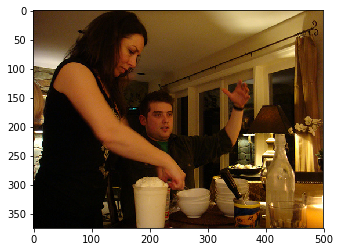

a man and a woman are standing in front of a party .
[1060 1571 2293 1060 2397 2505  558 1482 1239 2361 1060 1313]
[1060 1571 1482 1060    1 1841 2134 1060  360  694]
[1060 1571 1482 1060 1947 1402 2293 2196  618 1480  558 1482 1060 2472  337
 1060  186  562 1481]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480 1586 1661]
[]
[1060 1571 1480 2082  562 1060 1092  780 2269]
[1060 1571  337 1060 2127 2293  603 1480  845 1060 1217]
[1471 1377 1482 1106 2482 1600 1060 1349 2361 2304]
[1060 1580 2361  134 2505 1168 2293 1757]
[1060 1571 1482 1060 1622 1402 2293  966 1480  605 1060  976  562 1060 1951
 1482 1060 1779]
[1060 1571 2293 1060 2397 2505 2082  562 1060 1788]
[1060 1571 1482 1060 1622 1402 1480  558 1482 1060 2305 1393  337 1060 1015
 2361 2293]
[1060 1571 1480 2082  562 1060 1586 1482  804 2132]
[1060 2397 1482 1060 2286 1402 2293 1622 2677 1480 2082  562 1060 1721 2293
 1168 1060  325]
[1060 1571 1482 1060 1947 1534 1480 1586 1661]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1

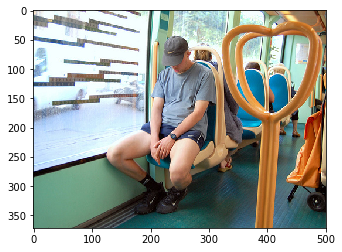

a young boy is sitting on a blue raft .
[1060  534 1551 1480 2082  562 1060 2062 1736]
[1060  534 1551 1482 1060 2062 1402 1480 1752  337 1060 2119  843]
[1060 1588 1482 1060 1560 1232  510 1480  558  562 1060  720  337 1060 2425
 1482  332  800]
[1060  853 1442 1660  562  804 2374]
[1060 1571 1482 1060 1947 1402 2293 1622 2677 1480  558 1482 1239 2361 1060
 1026]
[1060 1571 1482 1060 2062 1402 2293 2286  618 1480 1752 1517]
[1060 1724 2134 1060 1194  562 1060  267 1941]
[1060 1580 2361  134 2505 2082  562  804  129 2361 1060 2561  346 1060  594]
[1060 1622 1442 1480 1752  337 1060 2286 2293  853 1442]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480  265 1513  804 2060  337
 2497 1442]
[1060 1442 1480 1660  562  804  720  337 1060 1517  660 1482 2497   74]
[1060 1571 1482 1060 1947 1402 1480 1752  804  111 2293 1214]
[1060 1571 1482 1060 1947 1402 1480 1752 1060 2316]
[1060 1571 2293 1060  106 2505 1231 1482 1060 2011]
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480  227]
[1060  

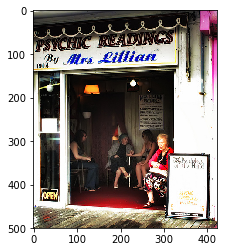

a man in a red shirt and a blue hat is standing in front of a store .
[1060 1571 1482 1060 1947 1402 2293 1060 2062  123 1480  558 1482 1239 2361
 1060 2472]
[1060 1571 1480 2705  562 1060  720 2440  337  804  402 2293 2566 1482  804
 1501]
[1060  534 1551 1480  845 1060  564]
[1060  312 1480  268 1513 1060  837 2450]
[1060  534 1588 1482 1060 1947  396 1480  919  346 1060 2119 1921  446]
[1060 1571 1482 1060 2062 1402 1480 1725 2540]
[1060 1571 1482 1060 2286 1402 2293 1622  123 1480  558 1482 1239 2361 1060
  536  671]
[1060 2397 1482 1060 1622 1534 1480  558 1482 1239 2361 1060 1026]
[1734 1377 2505 1355 1482 1060 2102]
[1060 1580 2361  134 2505  558 1482 1060 2313 1015 1412  337 1930 2293 1930
 1482  804 1501]
[1060 1571 1482 1060 1947 1402 2293 1622 2677 1480  265 1513  804 2060]
[1060 1580 2361 1273 2546 2505  200  562 1060 1688]
[1060 1571  337 1060 2316 1480 1752 1060 2316]
[1060 1571 1480  609 1060  981 2657 1480  935 1482 1060 2011]
[1060 1571 1482 1060 2286 1402 2293 1622 26

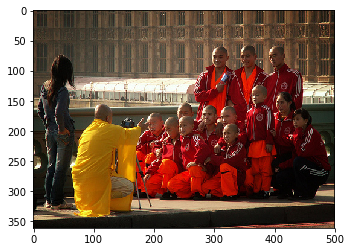

a group of people are standing in front of a building .
[1060 1580 2361  134 2505  558 1482 1239 2361 1060 1026]
[1060 2397 1482 1060 1622 1402 1480  845 1060 1081 1482 1060]
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480 2086 1482  804  789  337
 2497 1386 2211]
[1060 2397 1482 1060 1622 1402 1480  919  346 1060 1349 2361  407]
[1060 2397 1482 1060 1947  396 2134 1060 1040]
[1060 1580 2361  134 2505 1752 2444 1482 1060 1779]
[1060 2397 1482 1060 1947 2293 2286 2513 1480 2086 2091 1060 1955]
[1060 2397 1482 1060 2286 1402 2293  222 1480 1597]
[1060 1571 1482 1060 1947 1402 2293 1622 2677 1480  558 1482 1239 2361 1060
  186  938 2235 2465 2465]
[1060 1571 1482 1060 1622 1402 2293 2062  618  265 1513  804 2060]
[1060 1571 1482 1060 1622 1402 1200 1060 2316 2293 1214]
[1060 1571  337  603 1480  845 1060 1217]
[1060 1571 1482 1060    1 1402 2293 2062  966 1480  558  562 1060 2264  702
 1060  859]
[1060 1571 1480 2082  562 1060 2012 2293 1480  845 1060  368 2425]
[1060 1508 1480 1093  5

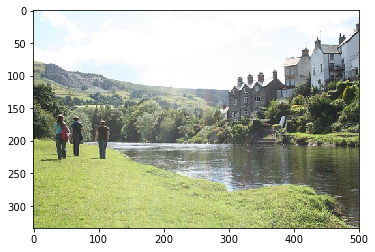

a group of people are walking through a field of tall grass .
[1060 1580 2361  134 2505  265 2308 1060 1705 2361 1575 2374]
[1060 1571 1482 1060 2286 1402 1480   16]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480 2082  562 1060 1788 2293
  200  562 1060 2182 1293]
[1060  534 1551 1480 1752  337 1060 2239  857]
[1060 2397  337 1060 1932  562  332 2205 1480  919  507  804 1855]
[1060   61  110 1482 1060 2286  864 1480 1017  362 1173 1060 1618 1865  804
  110]
[1060  853 1442 1480 1660 2308 1060  132  447 1060 2425]
[1060 2397 1482 1060  396  265 1513  804 2060]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480  558  562 2120 2361 1060
 2264]
[1060 2397 1482 1060 1622 1402 1480 2082  562 1060 1262  337 1060 2354 1482
  332]
[1060 1571 1482 1060 2286  222 1480   16]
[1060 2397 1482 1060 2286  396  265 1513  804 2060]
[1060 1601 1588 1482 1060 1947 1748 2293 2062  206  123 1480  558  562 1060
 2132 2631 2066]
[1060 2286 1442 1480 1660 2308  804 2374]
[1060 1571 1482 1060 1947 1402 2293

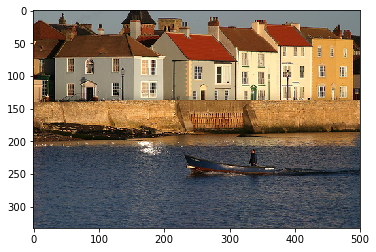

a man fishing in a beautiful lake .
[1060 1571 2705 1482 1060  395 2011]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480 2082  562 1060 2012 1482
 1239 2361 1060 2472]
[1060  994 1480  605 1060  486  562 1060  873]
[1060  534 1551 1482 1060 1947 1402 2293 1060 1601 1588 1482 1060 2286 1402
 2505 1752  337 1060 2119]
[1060 1580 2361  134 2505  558 1482 1060  516]
[1060 1571 1482 1060 2062 1402 1480 2393  518 2497 1618  346 1060  269 1159]
[1060 2217  183 1480  308  504 1060  133]
[1060 1571 1482 1060 2198  123 2134 1060 1092]
[1060 1580 2361 1377 2293 2612 2617  562  804  952 2087 1060 1026  337 1060
 1015 2361  861  562 1481]
[1060 1580 2361  534  134 2505 1752  404 1482 1060 1907 2361 2239]
[1060 1571 2293 1060  106 2505 1752 1482 1060 2651  132]
[1060 1580 2361  134 2505 2082  562 1060 1884]
[1060 1442 1480 2086  518  362 2170 1060  660 2455 1482 1060  371]
[1060 1571 1482 1060  510 2293 2215 1480 1752 1060 1148 2667]
[1060 1571 1482 1060 2286 1402 2293 1622  123 1480 1095  984]
[

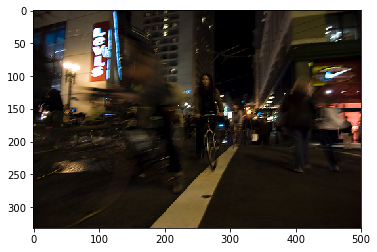

a man in a white shirt and black shorts is walking down the street .
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480  265 1513  804 2060]
[1060 1571 1482 1060 1622  123 2293 1060 2286 1402 1480  558 1482 1060  133]
[1060 2397 1482 1060 2286 1402 2293 1060 1571 1482 1060 2286 1402 1139  346
 1060  629 2361 1060 2397  164  627]
[1060 1580 2361  134 2505  558 2315 2130]
[1060 1580 2361  134 2505 2082  346 1060 2686  337 1060  727 1319]
[1060 1571 1480  558  562 1060 1394  337 1060 1928 1468 1060   42]
[1060 2397 1482 1060 1947 1402 2293 1622 1226 1480  558 1482 1239 2361 1060
 2031]
[1060  534 1588 1482 1060 1560 1402 1480 1752  337 1060 2119]
[1060 1571 1482 1060 2286 1402 1480 2082  346 1060 2686  337 1060 2737 1482
 1239 2361 2500]
[1060 1571 1482 1060 1622 2293 2286  864 1480  636 1060 1083  694  562 1060
 1612]
[1060  534 1551 1480  558  562 1060 2044  346  804 2120 2361 1060   69 1173
 2684]
[1060 2397 1482 1060 1622 1402 1480 2082  562 1060  174 2293 1757 1649]
[1734 1377 2505 2

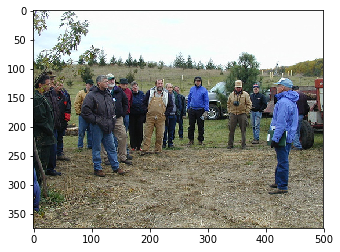

a group of people are standing in a field of grass and .
[1060 1580 2361  134 2505  558 1482 1060 1705 2361 2374 2293]
[1060 1601 1588 1482 1060 1560 1232  510 1480  558  562 1060 2043  720]
[1060 1571  347 1513 1060  859 1482 1239 2361 1060 1826 1094]
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480  265  337 1060 1517 1981
 1482 1060 1517 2014]
[1060 1571 1482 1060 2062 1402 1480  558  560  362 1060 2397 1482 1060 2286
 1402 2293 1622  618  346 1060 1498 1076]
[1060 1580 2361  134 2505 2082  562  804  952 2293 2669]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480  265  337 1060 2397 1482
 1060 2286  396 2293 1060 1622  123]
[1060 1571 1482 1060 1622 1402 2293  966 1480  265 1513 1060 2519  859]
[1060 2198 1480  636 1060 1092 1412 1372 1060 1571 1482 1060 2198  123 2134
  504]
[1060 1580 2361  134 2505 2082 1482 1060 1119  562 1060  957 2012]
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480  999 1060   89 2293  362
 1060  535]
[1060 1571  562 1060 1083  694 1480  636 1513 1060 

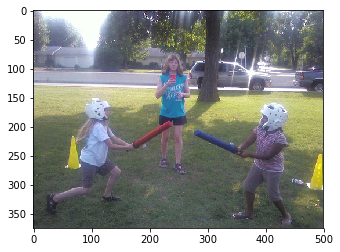

a little boy plays with a soccer ball on a tee .
[1060 1601 1551 1200  337 1060 2444  660  562 1060 2408]
[1060 1571 1482 1060 2286 1402 2293  603 1480 1752 1060]
[1060 2217  110 1482 1060 2286 2293  434  864 1480 1660  337 1060 2217  110
 1482 1060 2286  864]
[1060 1571 1480 2086 1482  804  789  562  804  720]
[1060   61  110 1482 1060 2286  864 1480 1017  362 1173 1060 1618 1865  804
  110]
[1060  534 1588 1482 1060 1301 1444  396 2293  845 1060 2402]
[1060 2397 1482 1060 2286 1402 2293 1060 2397 1482 1060 2286 1402 2505 2082
  346 1060 2686]
[1060 2397 1482 1060  396 1480  558 1482 1239 2361 1060 1855]
[1060 1580 2361 1377 2505 1660 1513 1060 2060]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480  558 1482 1239 2361 1060
  589]
[1060 1571 1482 1060 2286 1402 2293 2062  966 1480  558  562 1060   65 1254]
[1060 1571 1482 1060 2286 1402 2293 1060 1571 1482 1060 2286 1402 2505  558
  562 1060  906]
[1060 2217  110 1482 1060 2286 2293 2062  864 1480  189  362  804  952  337
  754  110 

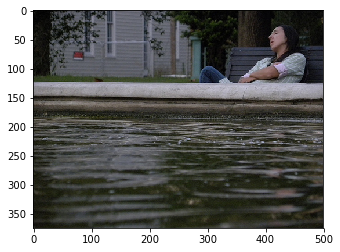

a man in a black shirt and shorts is sitting on the edge of a dock .
[1060 1571 1482 1060 1622 1402 2293  618 1480 2082  562  804 1438 2361 1060
  594]
[1060 1442 2555  362 2170 1060 1327]
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480 1752 1517]
[1060 1580 2361  134 2505 2082  346 1060 2686  337 1060 1293 1482 1239 2361
 1481]
[1060 2397 1482 1060 2286 1474 2120 2293 2143 1480  845 1060  298]
[1734 1426 1482 1560 2045 2293 2286 1027 1060 1571 1482 1060 2286 1402 2293
 1622 2677  848 2376]
[1060 1571 1482 1060 2286 1402 2293 1622  222 1480  558 1482 1239 2361 1060
  589 2361  739]
[1060 1571 1482 1060 1622 1402 2293 2062  966 1480  265 1513  804 2060]
[1060  534 1551 1480 2082  562 1060  174  337 2497 1238 1447]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480  558 1482 1239 2361 1060
 1580 2361  134]
[1060 2397 1482 1060 1622 1534 1480  558 2315 2361 1060 2472]
[1060 1571 2293 1060 2397 2505  558 1482 1060 1393  337 1060 2397 1482 1060
 1947  396]
[1060 2397 1482 1060 1947  396 

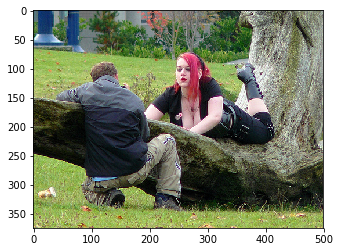

a man in a black shirt and blue jeans is sitting on a bench with his foot on a tree .
[1060 1571 1482 1060 1622 1402 2293 2062  966 1480 2082  562 1060 2012  337
 2497 1072  562 1060   65]
[1060 1571 1482 1060 2286 1402 2293 1060 1622  123 1480  919 2308 1060 2737]
[1060  534 1551 1480 2082  562 1060 2062 1117]
[1060 1571  337 1060 2127 2293 1060 2286 1402 2627  346 1060 1217]
[1060  534 1588 2086 2308  804  789  337  332   74  235]
[1060 1580 2361  134 2505 2082  346 1060 2686  337  161 2293 1060 1217]
[1060 1580 2361  134 2505 1787 1482 1060]
[1060  534 1588  614  732 1482 1060  335]
[1060 1580 2361  134 2505  265  562 1060 1083 1688]
[1060 1571 1480 2082  562 1060  594 2174 1060  289]
[1060 1571 1482 1060 2286 1402 2293 1622  123 1480 1095  984]
[1060 1571 1482 1060 2286 1402 2293 1060 2397 1482 1060 2286 1402 2505 2082
  562  804  952]
[1060 1580 2361  134 2505  558 1482 1239 2361 1060  880]
[1060 1622 1442 1480 1660 2308  804 2239]
[1060  534 1551 1482 1060 1947 1402 2293 1060 158

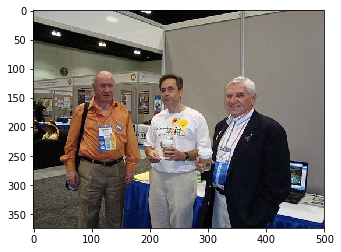

a group of people are standing in a line .
[1060 1580 2361  134 2505  558 1482 1060  516]
[1060 1580 2361  134 2505 2082  346 1060 2686  337 1060  368 2585 2293 1060
 2686 1482 1060 1816]
[1060  534 1551 1480 1752  337 1060 2119]
[1060 1571 1482 1060 2198  123 2134 1060 1092]
[1060 1580 2361  134 2505  265 1513 1060  859]
[1060  534 1551 1480  265 1513 1060 1083 1688 1482 1060]
[1060 1571 1482 1060 1622 1402 2293 1622 2677 1480  265 1513  804 2060]
[1060 1571 1482 1060 1947 1402 1480  558 1482 1239 2361 1060  133]
[1060 1571 1482 1060  123 1480  558  560  362 1060  464 2327]
[1060 1571 1482 1060 1622 1402 1480  558 1482 1239 2361 1060 2031 2293 1060
 2031]
[1060 1580 2361  134 2505 2082  346 1060 2686  337 1060  727 1319]
[1060  534 1551 1480 2082  562 1060  863]
[1060 1571 1482 1060 1622 1402 2293  966 1480 2082  562 1060 2012  337 1060
 1663 2361 2239]
[1060 1571 1482 1060 1947 1402 1480  265 2308 1060    9 1012]
[1060 1571 1482 1060 1947 1402 2293 1060 2286  123 1480 2082  562 1060 

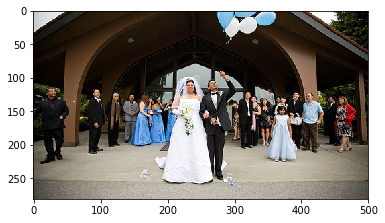

a bride and groom leaving after a wedding .
[1060 1100 2293  357 2601  722 1060 2146]
[1060 1571 1482 1060 2286 1402 2293 1622 2677 1480  558  562 1060 2264 1482
 1239 2361 1060  133 2361  134]
[1060 1571 1482 1060 1947 1402 2293 2286  618 1480 1752 1060  960]
[1060   61  110 1480 1982  362   91 1060 2432]
[1060  534 1571 1482 1060 2062 1402 2293  618 1480 1752 1517]
[1060  534 1551 1448 1060 1947 2293 2286 1978 1402 2293 2062 2180  618 1480
  558  562  804  859]
[1060 1571 2293 1060 2397 2505  558 1482 1060  783  337 2293 2708  134]
[1060 1571 1482 1060 1622 1402 1480 1752  804 1686]
[1060 2397 1482 1060 2286  396 2293 1622 1280 1480  265 1513  804 2060]
[1060 1508 1480 2036 1513 1060  648]
[1060 1442 1480 1660  562  804  370]
[1060 1571 2293 1060 2397 2505  265  562  804  720]
[1060 1571 1480 1073 1482 1060  444]
[1060 1571 2293 1060 2397 2505  558  560  362 1060 1037 2293 1166 2505  845
 1523]
[1060 1571 1482 1060 1622 1402 2293  966 1480 2082  562 1060 2012 1482 1239
 2361 1060 102

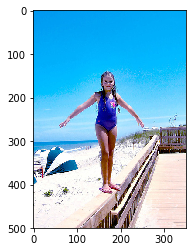

a girl in a bathing suit jumps into the water .
[1060 1588 1482 1060 1232  510 2555  507  804 2239]
[1060 1571 1482 1060 1622 1402 2293  123 1200  804 2316]
[1060 1571 1482 1060 2286 1402 2293 1060 2424  123 1480  200  562 1060 1394]
[1060 1580 2361  134  636 2421 1482 1060    9 1012]
[1060 1571 1482 1060 2286 1402 2293 1622  618 1480  558 1482 1239 2361 1060
  984 2362]
[1060 1580 2361  134 2505  558  313 2130]
[1060 2397 1482 1060 1947 1402 2293 1060 1601 1588 1482 1060 1560  123 2505
 2082  562 1060 1884]
[1060 1580 2361  134 2505 1660 1482 1060  541]
[1734 1713 2505 2082  562 1060  162  337 1060 2119]
[1060 1571 1482 1060 1622  123 2293 2062 1402 1480 2082  562 1060 1170  337
 2497   63 1222]
[1060 1571 1482 1060 2286 1402 2293 1622 2333 1480  558  562 1060 2264  337
 1060 2475 1482 2497 1853]
[1060 1571 1482 1060 1947 1402 2293 1060 2397 1482 1060 2286 1402 2505  558
 1482 1060 1688 1475 1060  464]
[1060 1571 1482 1060 1622 1402 2293  966 1480 1752 1060 2316  562 1060 1219]
[1060 

In [ ]:
evaluation('data/flickr30k/', 'models/model-51')